<a href="https://colab.research.google.com/github/ubaidillahfadhil/deep_learn/blob/main/blackpink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [2]:
!kaggle datasets download ubaidillahfadhil/wajah-blackpink
!mkdir blackpink


 84% 56.0M/66.9M [00:00<00:00, 113MB/s]
100% 66.9M/66.9M [00:00<00:00, 114MB/s]


In [ ]:
!unzip /content/wajah-blackpink.zip -d /content/blackpink

In [5]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [6]:
dataset_path = Path(r'/content/blackpink/black pink')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/blackpink/black pink/jennie/10940.jpg,jennie
1,/content/blackpink/black pink/jennie/11043.jpg,jennie
2,/content/blackpink/black pink/jennie/12644.jpg,jennie
3,/content/blackpink/black pink/jennie/10939.jpg,jennie
4,/content/blackpink/black pink/jennie/12987.jpg,jennie


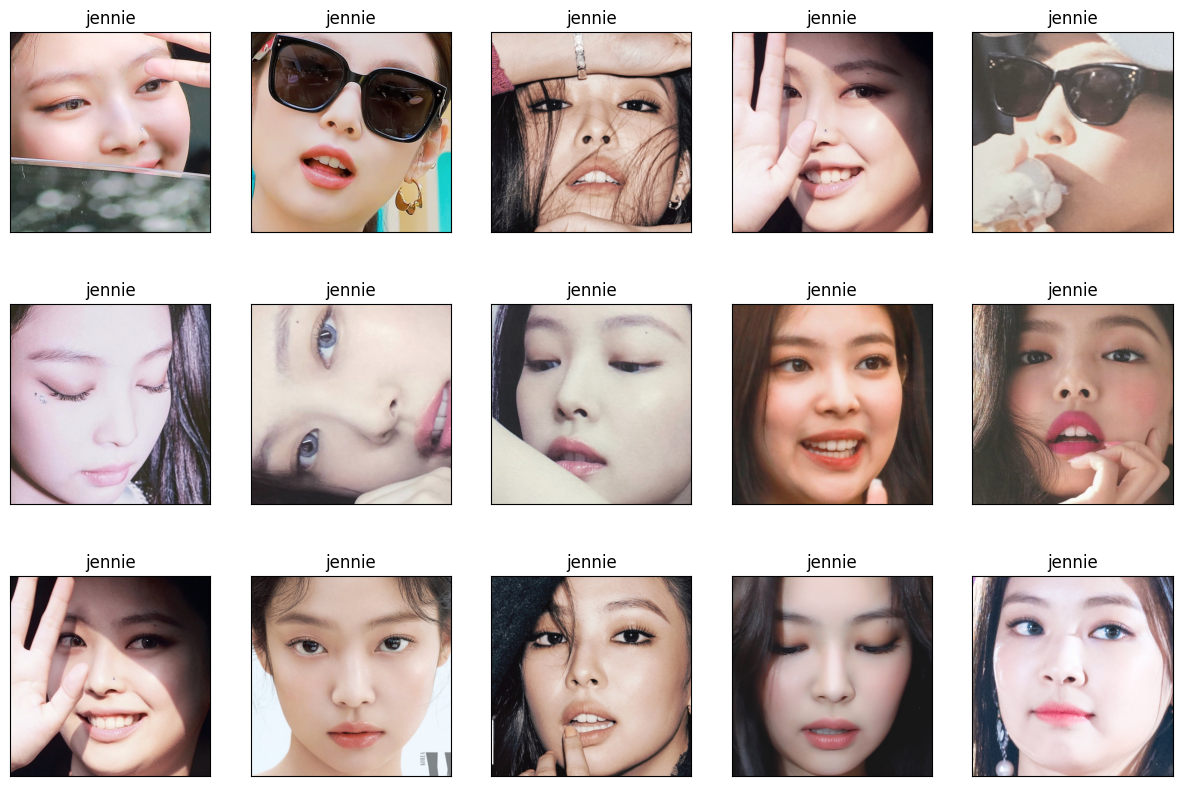

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()
     

In [9]:
df.label.value_counts()

jennie    100
rose      100
lisa      100
jiso      100
Name: label, dtype: int64

In [10]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

jennie    100
rose      100
lisa      100
jiso      100
Name: label, dtype: int64

In [11]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [12]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (224, 2)
Shape of test data (120, 2)
Shape of validation data (56, 2)


In [14]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)
 

Found 224 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.


In [15]:
input_shape = (200, 200, 3)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [17]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
7/7 [==============================] - 43s 6s/step - loss: 1.4001 - accuracy: 0.2321 - val_loss: 1.3882 - val_accuracy: 0.1964
Epoch 2/100
7/7 [==============================] - 38s 5s/step - loss: 1.3913 - accuracy: 0.2545 - val_loss: 1.3884 - val_accuracy: 0.1964
Epoch 3/100
7/7 [==============================] - 35s 5s/step - loss: 1.3879 - accuracy: 0.2277 - val_loss: 1.3861 - val_accuracy: 0.3036
Epoch 4/100
7/7 [==============================] - 37s 5s/step - loss: 1.3855 - accuracy: 0.2634 - val_loss: 1.3816 - val_accuracy: 0.3036
Epoch 5/100
7/7 [==============================] - 33s 5s/step - loss: 1.3883 - accuracy: 0.2455 - val_loss: 1.3815 - val_accuracy: 0.3571
Epoch 6/100
7/7 [==============================] - 34s 5s/step - loss: 1.3646 - accuracy: 0.2946 - val_loss: 1.3667 - val_accuracy: 0.3571
Epoch 7/100
7/7 [==============================] - 39s 5s/step - loss: 1.2806 - accuracy: 0.3750 - val_loss: 1.3708 - val_accuracy: 0.3214
Epoch 8/100
7/7 [==========

In [18]:
model.save('model-1.h5')

In [19]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

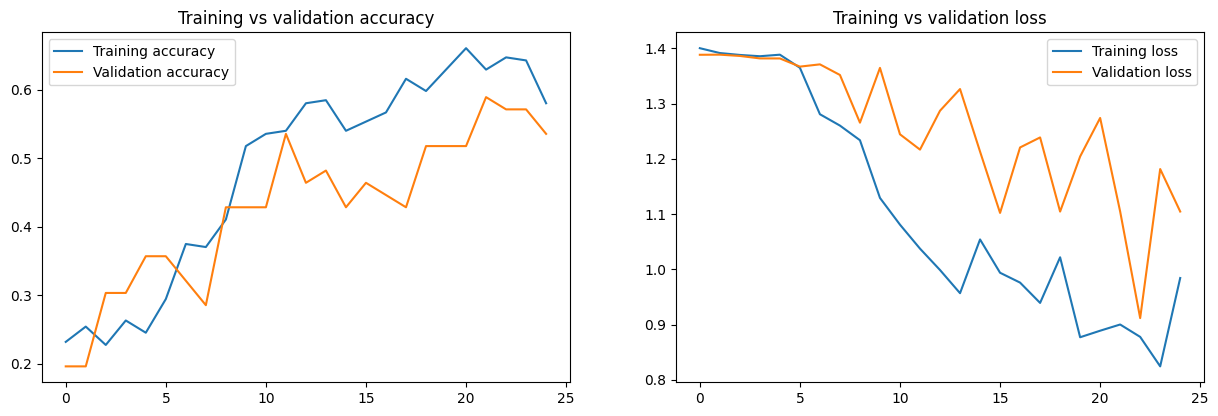

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [21]:
pred = model.predict(test)

4/4 [==============================] - 7s 1s/step


In [22]:
pred = np.argmax(pred, axis=1)

In [23]:
labels = train.class_indices

In [24]:
labels

{'jennie': 0, 'jiso': 1, 'lisa': 2, 'rose': 3}

In [25]:
labels = dict((v,k) for k, v in labels.items())

In [26]:
labels

{0: 'jennie', 1: 'jiso', 2: 'lisa', 3: 'rose'}

In [27]:
y_pred = [labels[k] for k in pred]

In [28]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

      jennie       0.44      0.27      0.33        30
        jiso       0.37      0.42      0.39        31
        lisa       0.40      0.77      0.53        26
        rose       0.53      0.27      0.36        33

    accuracy                           0.42       120
   macro avg       0.44      0.43      0.40       120
weighted avg       0.44      0.42      0.40       120



In [29]:
print(confusion_matrix(x_test.label, y_pred))

[[ 8  9 11  2]
 [ 6 13  8  4]
 [ 2  2 20  2]
 [ 2 11 11  9]]


In [30]:
test_accuracy = model.evaluate(test)[1]

4/4 [==============================] - 10s 3s/step - loss: 1.2031 - accuracy: 0.4917
